In [1]:
#Import Stuff
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# Errors

Here we will look at error calculations. The book covers the same material in chapter 8 in a slightly different way. I think this is the most simple way to understand error, it also gives us a tiny peak into time series calculations - or situations where we have a dataset that is a series of values. 

In [7]:
df = pd.read_csv("data/GasTimeSeries.csv")
df.head()

,Day,Price
0,1,1.48
1,2,1.51
2,3,1.49
3,4,1.46
4,5,1.42


### Data - Time Series

Our data is a list of gas prices - the average of several gas stations in one city. We have 30 days of data. If our goal is to predict the price on day 31 we have several ways we could do it - this is time series analysis that we'll look at a bit more later. For now, we'll look at the most simple way - take an average. 

My simple algorithm for predicting the next day's gas price will simply average together the previous 5 days of data, and that will be the prediction for the next day. This is kind of what we do in lots of situations - how much will a bake sale yeild? How long will it take to drive to Calgary? How many people will be ahead of me in line at Starbucks? We can average the previous few values together and use that as a projection. There obviously are more advanced ways to predict this, for now we'll use this simple way because we are just looking for error. 

In [8]:
#Average together last 5 values. 
avg5 = df["Price"].tail(5).mean()
avg5

1.468

Now, we have a projected value for tomorrow. However, what if my friend says "averaging 5 days is silly, I'm going to only use the past 3!"

In [15]:
#Average together last 5 values. 
avg3 = df["Price"].tail(3).mean()
avg3

1.4400000000000002

### Evaluating Predictions

Ok, now we both have predictions, but who's prediction is more accurate? We have no idea. 

The way that we can evaluate predictions against eachother is by running trials where we know the answer, and comparing our prediction to real values. This basic idea holds true for the machine learning stuff we do later on. The generallized process is:

- Use some algorithms to create some models that make predictions.

- Use those models on some old (test) data, where we know the actual, real outcome.

- Compare our predictions to those known values - the closer we are, the more accurate that model is. 

- Choose the most accurate (usually - there's sometimes other factors) model, as its predictions are the best.


So, for our gas price scenario here:

- We have two models - a 3 day average and a 5 day average. We could have more, including sophisticated ones.

- Run our old (test) data through the models to generate a prediction. We also know the correct values for these predictions.

- For each prediction, calculate how wrong it is - the error. (Aka the residual).

- Tally up the errors to a single metric of error. 

In [19]:
#Add old predictions
#Note: to figure out the command I Googled "dataframe moving average" and got the rolling function
df["avg5"] = df["Price"].rolling(5, closed="left").mean()
df["avg3"] = df["Price"].rolling(3, closed="left").mean()
df.head(10)

,Day,Price,avg5,avg3
0,1,1.48,NaN,NaN
1,2,1.51,NaN,NaN
2,3,1.49,NaN,NaN
3,4,1.46,NaN,1.493333
4,5,1.42,NaN,1.486667
5,6,1.48,1.472,1.456667
6,7,1.59,1.472,1.453333
7,8,1.61,1.488,1.496667
8,9,1.53,1.512,1.560000
9,10,1.51,1.526,1.576667


If we look at the line for day 6:

- The real value is 1.48.

- The 5 day model predicts 1.472.

- The 3 day model predicts 1.457. 

So the 5 day model is off by .08, while the 3 day model is off by .23 - apx three times as much error. 

Every one of these old predictions will have an error like this, we can populate them in the table.

In [20]:
#Calculate the residuals (errors) and put them into the table
df["res5"] = df["Price"]-df["avg5"]
df["res3"] = df["Price"]-df["avg3"]
df.head(10)

,Day,Price,avg5,avg3,res5,res3
0,1,1.48,NaN,NaN,NaN,NaN
1,2,1.51,NaN,NaN,NaN,NaN
2,3,1.49,NaN,NaN,NaN,NaN
3,4,1.46,NaN,1.493333,NaN,-0.033333
4,5,1.42,NaN,1.486667,NaN,-0.066667
5,6,1.48,1.472,1.456667,0.008,0.023333
6,7,1.59,1.472,1.453333,0.118,0.136667
7,8,1.61,1.488,1.496667,0.122,0.113333
8,9,1.53,1.512,1.560000,0.018,-0.030000
9,10,1.51,1.526,1.576667,-0.016,-0.066667


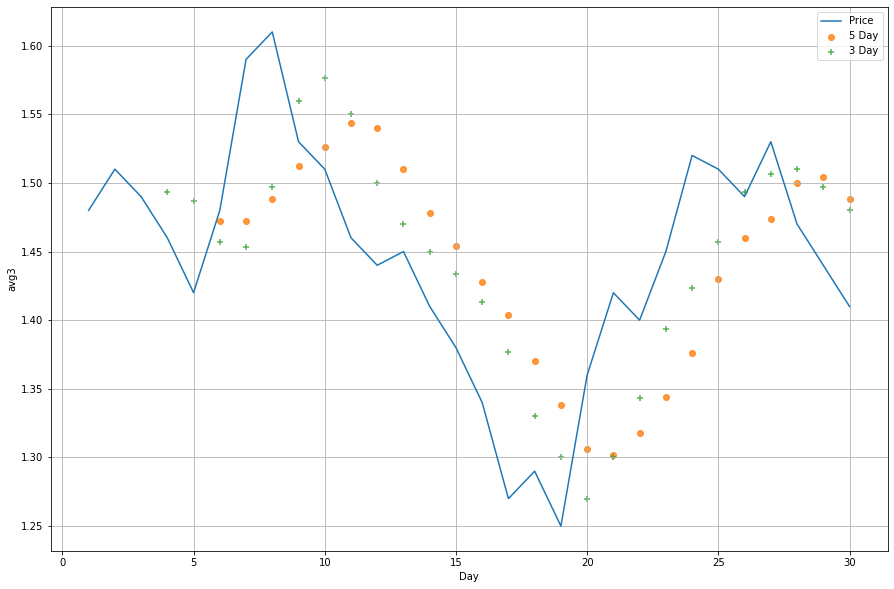

In [58]:
#Graph them to take a look
plt.rcParams["figure.figsize"] = (15,10)
sns.lineplot(x="Day", y="Price", data=df, label="Price")
sns.regplot(x="Day", y="avg5", data=df, fit_reg=False, label="5 Day")
sns.regplot(x="Day", y="avg3", data=df, fit_reg=False, label="3 Day", marker="+")
plt.legend()
plt.grid()
plt.show()

### Exploring the Residuals

If we look at the two residual columns we can make some sense of it. If one model has smaller residuals, it is more accurate. 

It isn't really practical to have a massive column of errors, especially with a real amount of data, so we have ways to aggregate these individual errors into total metrics. For example, we can average all the errors together:

In [21]:
df[["res5", "res3"]].mean()

res5   -0.001120
res3   -0.004815
dtype: float64

This way is pretty dumb though, since if we predict 5c too high one time, and 5c too low another, that will average out to no error - obviously not really a good calculation in most cases. What if we take the absolute values, to remove that issue?

In [22]:
df[["res5", "res3"]].abs().mean()

res5    0.076000
res3    0.061852
dtype: float64

### Error Metrics

Better, a more realistic estimate of the error. 

In most cases however, we don't use the absolute value to deal with negatives, we use squaring. There are a few reasons for this:

- Simple: small errors are 'penalized' less than large errors when squaring. 

- Lazy: it is extremely common, well understood, and implemented all over the place. 

- Mathy: absolute value calculations generally suck when doing real math. Squaring gives the most 'efficient' estimation of errors - you need the smallest number of values to create an estimate, for math reasons we really don't care about: https://en.m.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem

We can calculate a common error metric, MSE - mean squared error. Which is just what it sounds like. 

In [25]:
df[["res5", "res3"]].pow(2).mean()

res5    0.007084
res3    0.004879
dtype: float64

Another very common error metric is RMSE - root mean squared error, which is just the square root of the MSE

In [30]:
#Calculate RMSE
e5, e3 = df[["res5", "res3"]].pow(2).mean()
np.sqrt(e5), np.sqrt(e3)

(0.0841674521415494, 0.06985287301401968)

So, for these calculations the 3 day average model is more accurate with our data. With new data, there's no assurance that it will continue to be more accurate, but based on the data we have, we can trust it more. The more old (training) data we have, the more robust these error caclulations will generally be. 

We don't need to do this by hand, there are existing functions that do it for us...

In [34]:
#Calculate RMSE using prebuilt functions. Hopefully the results are the same!!
from sklearn.metrics import mean_squared_error
# real value
expected = df["Price"]
#Note: The iloc thing selects the rows. The function can't deal with missing values.
# predicted value
predicted5 = df["avg5"].iloc[5:]
predicted3 = df["avg3"].iloc[3:]
# calculate errors. Change squared to True to get MSE
errors5 = mean_squared_error(expected.iloc[5:], predicted5, squared=False)
errors3 = mean_squared_error(expected.iloc[3:], predicted3, squared=False)
errors5, errors3

(0.08416745214154939, 0.06985287301401968)

### Errors - MSE and RMSE

There are a lot of different ways to calculate the error, RMSE is probably the one that matters most for use, MSE is also used/seen sometimes. 

<b>Note:</b> MSE and RMSE can be really impacted by outliers. Think about why. Another common error measure - mean absolute error tends to be less impacted by outliers. Think about why. 

The basic idea of every error cacluation is just like this simple example - what is the prediction, what is the expected value, how much do they differ, how do we aggregate those differences into a value. (Classification errors are different, we'll worry about that later)

## Exercise

<ul>
<li>Calculate a 4 day moving average and a 6 day moving average. 
<li>Which is a more reliable prediction model? Why?
</ul>

In [ ]:
# Code here